In [ ]:
!pip install langchain -q
!pip install openai -q

In [14]:
%pip install --upgrade --quiet  langchain langchain-community langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import sqlite3

In [3]:
df = pd.read_csv('/content/income (1).csv')

In [4]:
df.rename(columns={
    'Name':'name',
    'Age':'age',
    'Income($)':'income'
})

,name,age,income
0,Rob,27,70000
1,Michael,29,90000
2,Mohan,29,61000
3,Ismail,28,60000
4,Kory,42,150000
5,Gautam,39,155000
6,David,41,160000
7,Andrea,38,162000
8,Brad,36,156000
9,Angelina,35,130000


In [5]:
conn = sqlite3.connect('income.sqlite')
c=conn.cursor()
c.execute('CREATE TABLE IF NOT EXISTS income_details (name text, age int,income int)')
conn.commit()

In [6]:
df.to_sql('income_details', conn, if_exists='replace', index = False)

c.execute('''
SELECT name FROM income_details LIMIT 10
           ''')

for row in c.fetchall():
  print (row)

('Rob',)
('Michael',)
('Mohan',)
('Ismail',)
('Kory',)
('Gautam',)
('David',)
('Andrea',)
('Brad',)
('Angelina',)


In [7]:
def read_sql_query(sql, db):
    conn = sqlite3.connect(db)
    cur = conn.cursor()
    cur.execute(sql)
    rows = cur.fetchall()
    for row in rows:
        print(row)
    conn.close()

In [8]:
read_sql_query('SELECT * FROM income_details LIMIT 10;',
               "income.sqlite")

('Rob', 27, 70000)
('Michael', 29, 90000)
('Mohan', 29, 61000)
('Ismail', 28, 60000)
('Kory', 42, 150000)
('Gautam', 39, 155000)
('David', 41, 160000)
('Andrea', 38, 162000)
('Brad', 36, 156000)
('Angelina', 35, 130000)


In [10]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = 'OPENAI_API_KEY'

# Uncomment the below to use LangSmith. Not required.
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()
# os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [11]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///income.sqlite")
#content/income.sqlite
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM income_details;")

sqlite
['income_details']


"[('Rob', 27, 70000), ('Michael', 29, 90000), ('Mohan', 29, 61000), ('Ismail', 28, 60000), ('Kory', 42, 150000), ('Gautam', 39, 155000), ('David', 41, 160000), ('Andrea', 38, 162000), ('Brad', 36, 156000), ('Angelina', 35, 130000), ('Donald', 37, 137000), ('Tom', 26, 45000), ('Arnold', 27, 48000), ('Jared', 28, 51000), ('Stark', 29, 49500), ('Ranbir', 32, 53000), ('Dipika', 40, 65000), ('Priyanka', 41, 63000), ('Nick', 43, 64000), ('Alia', 39, 80000), ('Sid', 41, 82000), ('Abdul', 39, 58000)]"

###Chain
Let's create a simple chain that takes a question, turns it into a SQL query, executes the query, and uses the result to answer the original question

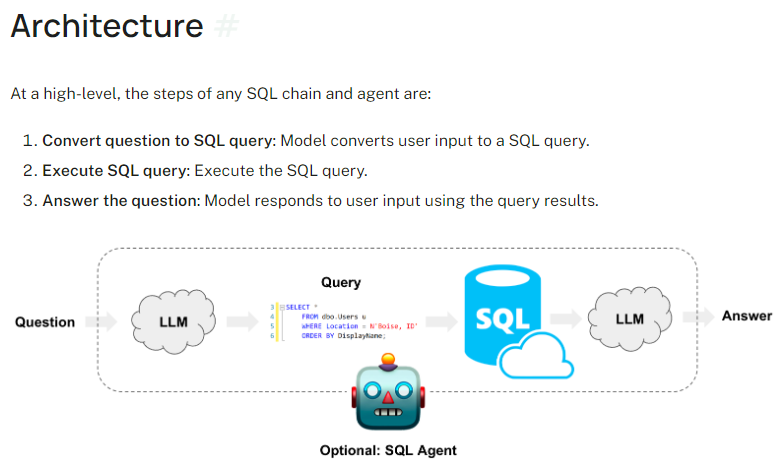


Convert question to SQL query

In [16]:
from langchain.chains import create_sql_query_chain
#This chain generates SQL queries for the given database

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
chain = create_sql_query_chain(llm, db)
response = chain.invoke({"question": "How many employees are there"})
response

'SELECT COUNT("Name") AS "Total Employees" FROM income_details\nLIMIT 1;'

In [17]:
db.run(response)

'[(22,)]'

In [18]:
chain.get_prompts()[0].pretty_print()

You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 5 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use date('now') function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result

###Execute SQL Query
Now that we've generated a SQL query, we'll want to execute it. We can use the QuerySQLDatabaseTool to easily add query execution to our chain

In [19]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

execute_query = QuerySQLDataBaseTool(db=db)
write_query = create_sql_query_chain(llm, db)
chain = write_query | execute_query
chain.invoke({"question": "How many employees are there"})

'[(22,)]'

###Answer the question
Now that we've got a way to automatically generate and execute queries, we just need to combine the original question and SQL query result to generate a final answer. We can do this by passing question and result to the LLM once more

In [20]:
from operator import itemgetter

from langchain_core.output_parsers import StrOutputParser
#OutputParser that parses LLMResult into the top likely string.

from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

answer_prompt = PromptTemplate.from_template(
    """Given the following user question, corresponding SQL query, and SQL result, answer the user question in a funny way.

Question: {question}
SQL Query: {query}
SQL Result: {result}
Answer: """
)

answer = answer_prompt | llm | StrOutputParser()
chain = (
    RunnablePassthrough.assign(query=write_query).assign(
        result=itemgetter("query") | execute_query
    )
    | answer
)

chain.invoke({"question": "Name top 3 youngest employess with salary more than $35,000"})

"Well, it looks like Tom, Rob, and Arnold are the youngest employees making more than $35,000. Looks like they're young, wild, and making money moves!"